In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

In [2]:
import colorterms

In [3]:
colorterms.load_catalogs(path='../catalogs')

In [4]:
lbda = colorterms.CATALOGS['gunnstryker'][1]['lbda']
flux = colorterms.CATALOGS['gunnstryker'][1]['flux']

In [5]:
spec = colorterms.Spectrum(lbda, flux, fpath="../filtersets")

In [6]:
%matplotlib inline
import pylab as plt

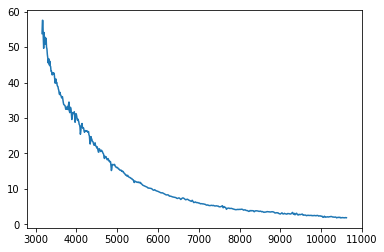

In [7]:
plt.plot(lbda, flux)

In [8]:
magMega = spec.mag(syst='megacam', filt='g')
magSDSS = spec.mag(syst='sdss', filt='g')
print(magMega, magSDSS)

((-38.67289197460465, None), (-38.19759506605211, None))


In [9]:
# shortcut
cat = colorterms.CATALOGS['gunnstryker']
magMega = [cat[i]['spec'].mag(syst='megacam', filt='g')[0] for i in cat]
magSDSS = [cat[i]['spec'].mag(syst='sdss', filt='g')[0] for i in cat]

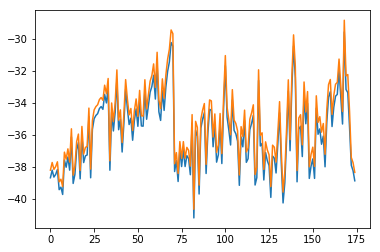

In [10]:
import numpy as np
x = np.arange(len(colorterms.CATALOGS['gunnstryker']))
plt.plot(x, magMega, x, magSDSS)

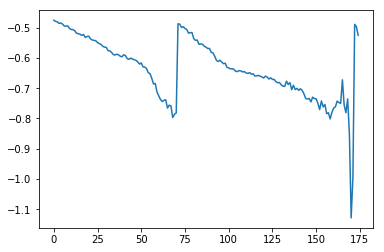

In [11]:
plt.plot(x, np.asarray(magMega)-np.asarray(magSDSS))